In [22]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

## 1. Data collection 

In [23]:
nasdaq = pd.read_excel("NASDAQ.xlsx")
tickers = nasdaq['Symbol']
tickers_list = list()
for ticker in tickers:
    tickers_list.append(ticker)

In [24]:
#data = yf.download(tickers_list,'2019-01-02','2019-12-31')
#data.to_pickle('ticker_data')

In [25]:
#stock data
data = pd.read_pickle('ticker_data')
data = data.drop(columns = ['Low', 'High', 'Open', 'Close'])
#market index data
index = pd.read_csv('index_ixic.csv', sep=",")
index = index.drop(columns = ['Low', 'High', 'Open', 'Close']) 

In [26]:
adj_close = data['Adj Close'] # adjusted closing price
volume = data['Volume'] # sales volume

adj_close.reset_index(level=0, inplace=True) # set index from date to int
volume.reset_index(level=0, inplace=True)

for i in range(0, len(adj_close['Date'])):
    volume.loc[i, 'Date'] = str(volume['Date'][i].date())
    adj_close.loc[i, 'Date'] = str(adj_close['Date'][i].date())


adj_indexes = set(adj_close['Date'].to_list())
ind_indexes = set(index['Date'].to_list())
diff = adj_indexes.difference(ind_indexes)
diff, adj_close.shape

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


({'2019-11-28'}, (252, 5014))

In [12]:
adj_close = adj_close.loc[adj_close['Date'] != '2019-11-28']
volume = volume.loc[volume['Date'] != '2019-11-28']
#handling missing values
adj_close = adj_close.dropna(axis=1, how='any')
volume = volume.dropna(axis=1, how='any')
#add the index data to the main data
adj_close['IXIC'] = index['Adj Close']
volume['IXIC'] = index['Volume']
adj_close = adj_close.loc[adj_close['Date'] != '2019-12-30']
volume = volume.loc[volume['Date'] != '2019-12-30']

In [13]:
#reduce the number of tickers
tickers_to_delete = adj_close.columns.to_list()
tickers_to_delete.remove('Date')
tickers_to_delete.remove('IXIC')
tickers_to_delete = tickers_to_delete[::2]
adj_close.drop(tickers_to_delete, inplace=True, axis=1) 
volume.drop(tickers_to_delete, inplace=True, axis=1) 

In [14]:
adj_close

,Date,AADR,AAOI,AAPL,AAXJ,ABEO,ABMD,ABUS,ACB,ACER,...,ZBRA,ZEST,ZG,ZION,ZIOP,ZKIN,ZNGA,ZSAN,ZYNE,IXIC
0,2019-01-02,39.938866,15.88,38.439735,60.990410,7.03,309.959991,4.00,62.880001,21.450001,...,156.240005,3.775,30.350000,38.495026,2.21,1.570,3.98,2.34,3.72,6665.939941
1,2019-01-03,39.493225,15.06,34.610851,59.549995,6.62,302.290009,3.77,61.680000,20.400000,...,146.880005,4.000,30.020000,38.282089,2.15,1.471,3.92,2.41,3.67,6463.500000
2,2019-01-04,41.028198,15.54,36.088364,61.512444,7.02,313.440002,4.10,62.639999,21.500000,...,152.970001,4.500,30.809999,39.457855,2.24,1.670,4.02,2.64,4.00,6738.859863
3,2019-01-07,41.513439,15.68,36.008041,61.879795,7.51,314.799988,4.20,63.119999,23.090000,...,155.289993,4.300,30.980000,39.615250,2.27,1.700,4.07,2.72,4.00,6823.470215
4,2019-01-08,41.800625,16.01,36.694466,62.044132,7.31,318.420013,4.05,60.360001,23.500000,...,156.330002,4.000,31.809999,39.976315,2.19,1.550,4.14,2.77,4.12,6897.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2019-12-20,53.408195,11.12,69.041237,71.936523,3.12,162.889999,2.89,27.000000,3.830000,...,252.490005,5.000,43.540001,49.132927,4.96,1.260,6.26,1.38,6.21,8945.650391
247,2019-12-23,53.537758,11.15,70.167885,71.966080,3.63,170.440002,2.75,24.120001,3.890000,...,256.730011,5.000,44.099998,48.856956,4.96,1.310,6.28,1.41,6.06,8952.879883
248,2019-12-24,53.816807,11.12,70.234581,71.749290,3.60,172.300003,2.75,23.879999,3.970000,...,254.330002,5.000,44.700001,49.037762,5.18,1.320,6.33,1.39,6.00,9022.389648
249,2019-12-26,54.115791,11.61,71.628067,72.192734,3.60,171.009995,2.62,24.000000,3.920000,...,254.419998,5.000,45.320000,49.161484,4.95,1.310,6.30,1.40,5.87,9006.620117


## 2. Logarithmic returns, expected value and standard deviation estimations


In [15]:
# calculate logarithmic returns
log_returns = pd.DataFrame(index = adj_close.index, columns = adj_close.columns)
log_returns['Date'] = adj_close['Date']
tickers = adj_close.columns.to_list()
tickers.remove('Date')
for ticker in tickers:
    log_returns[ticker] = np.log(1 + adj_close[ticker].pct_change())

In [16]:
log_returns

,Date,AADR,AAOI,AAPL,AAXJ,ABEO,ABMD,ABUS,ACB,ACER,...,ZBRA,ZEST,ZG,ZION,ZIOP,ZKIN,ZNGA,ZSAN,ZYNE,IXIC
0,2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,-0.011221,-0.053018,-0.104924,-0.023900,-0.060091,-0.025056,-0.059219,-0.019268,-0.050190,...,-0.061777,0.057894,-0.010933,-0.005547,-0.027525,-0.065133,-0.015190,0.029476,-0.013532,-0.030840
2,2019-01-04,0.038130,0.031375,0.041803,0.032423,0.058668,0.036221,0.083912,0.015444,0.052518,...,0.040626,0.117783,0.025975,0.030251,0.041008,0.126881,0.025190,0.091152,0.086103,0.041720
3,2019-01-07,0.011758,0.008969,-0.002228,0.005954,0.067472,0.004330,0.024098,0.007634,0.071347,...,0.015052,-0.045462,0.005503,0.003981,0.013304,0.017805,0.012361,0.029853,0.000000,0.012477
4,2019-01-08,0.006894,0.020828,0.018884,0.002652,-0.026992,0.011434,-0.036368,-0.044711,0.017601,...,0.006675,-0.072321,0.026439,0.009073,-0.035878,-0.092373,0.017053,0.018215,0.029559,0.010718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2019-12-20,0.008244,-0.016057,-0.002073,0.003156,-0.471605,-0.039365,0.237081,-0.008850,-0.033379,...,-0.002532,0.015114,-0.020235,0.002715,-0.033700,-0.054067,-0.003190,-0.007220,-0.008019,0.002316
247,2019-12-23,0.002423,0.002694,0.016187,0.000411,0.151400,0.045308,-0.049656,-0.112795,0.015544,...,0.016653,0.000000,0.012780,-0.005633,0.000000,0.038915,0.003190,0.021506,-0.024451,0.000808
248,2019-12-24,0.005199,-0.002694,0.000950,-0.003017,-0.008299,0.010854,0.000000,-0.010000,0.020357,...,-0.009392,0.000000,0.013514,0.003694,0.043399,0.007605,0.007930,-0.014286,-0.009950,0.007734
249,2019-12-26,0.005540,0.043121,0.019646,0.006161,0.000000,-0.007515,-0.048427,0.005013,-0.012674,...,0.000354,0.000000,0.013775,0.002520,-0.045417,-0.007605,-0.004751,0.007168,-0.021905,-0.001749


In [17]:
#calculate the estimates of the mathematical expectation and variance for each stock
ListOfStats = ['Mean', 'Std']

stats = pd.DataFrame(columns = ListOfStats, index = tickers)

for ticker in tickers:
    mean = np.mean(log_returns[ticker]) # 
    std = np.std(log_returns[ticker]) # variance (дисперсия), должно быть стандартное отклонение 
    
    stats['Mean'][ticker] = mean
    stats['Std'][ticker] = std
    
stats

,Mean,Std
AADR,0.001235,0.008494
AAOI,-0.001289,0.035969
AAPL,0.002498,0.016628
AAXJ,0.000701,0.009755
ABEO,-0.002894,0.074221
...,...,...
ZKIN,-0.000789,0.04445
ZNGA,0.001812,0.015591
ZSAN,-0.00215,0.081934
ZYNE,0.001756,0.053853


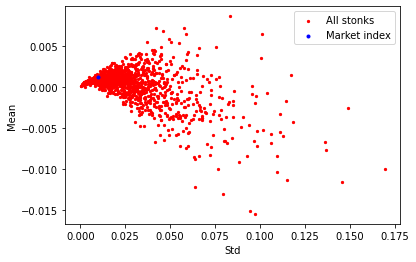

In [18]:
stats.plot(x='Std', y='Mean', color="red", kind="scatter", marker=".", label='All stonks') # лайк за стонкс) 
plt.scatter(stats['Std']['IXIC'], stats['Mean']['IXIC'], marker=".", color="blue", label='Market index')
plt.legend()
plt.show()

## 3-4. Equally weighted portfolio, stock market index  

In [19]:
#equally weighted portfolio return
sum_returns = 0
for ticker in tickers:
    sum_returns += stats['Mean'][ticker]
    
mean_balanced = sum_returns/len(tickers)
for i in range(len)

var_balanced = np.var(balanced_return) # std

SyntaxError: invalid syntax (<ipython-input-19-3ea43956b455>, line 7)

NameError: name 'var_balanced' is not defined

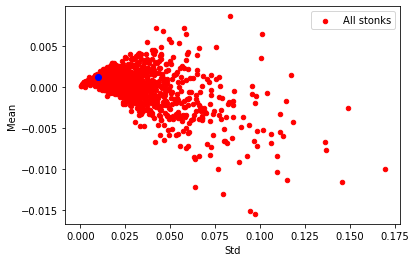

In [21]:
stats.plot(x='Std', y='Mean', color="red", kind="scatter", label='All stonks')
plt.scatter(stats['Std']['IXIC'], stats['Mean']['IXIC'], color="blue", label='Market index')
plt.scatter(var_balanced, mean_balanced, color="green", label='Balanced portfolio')
plt.legend()
plt.show()

# 5. VaR

In [ ]:
#VaR_gam = mu + sigma*U_gamma where U_gamma is Z-score? wtf

gamma1 = 0.95
gamma2 = 0.90

gamma_quantile1 = scipy.stats.norm.ppf(gamma1) # percentage point function
gamma_quantile2 = scipy.stats.norm.ppf(gamma2)

z_score1, z_score2

VaR1 = stats['Std']*gamma_quantile1 + stats['Mean']
VaR2 = stats['Std']*gamma_quantile2 + stats['Mean']

(1.6448536269514722, 1.2815515655446004)

## 6. White noise

## 7. 

## 8. 